# Dataset A 
Chest X-Ray (Pneumonia,Covid-19,Tuberculosis)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms,datasets, models
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from torch import nn, optim
import torch.nn.functional as F
import time
import copy


In [27]:
data_dir = r"C:\Users\ismaeeel\Downloads\archive (1)\train" 
dataset = datasets.ImageFolder(data_dir)

# Define split sizes
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Shuffle & split the data
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_split_end = int(np.floor(train_split * dataset_size))
val_split_end = train_split_end + int(np.floor(val_split * dataset_size))

train_indices = indices[:train_split_end]
val_indices = indices[train_split_end:val_split_end]
test_indices = indices[val_split_end:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_transforms = transforms.Compose([
    transforms.Resize(150),
    transforms.RandomResizedCrop(150),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transforms = {
    'train': train_transforms,
    'val': val_transforms,
}

# Apply transformations
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms



In [29]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

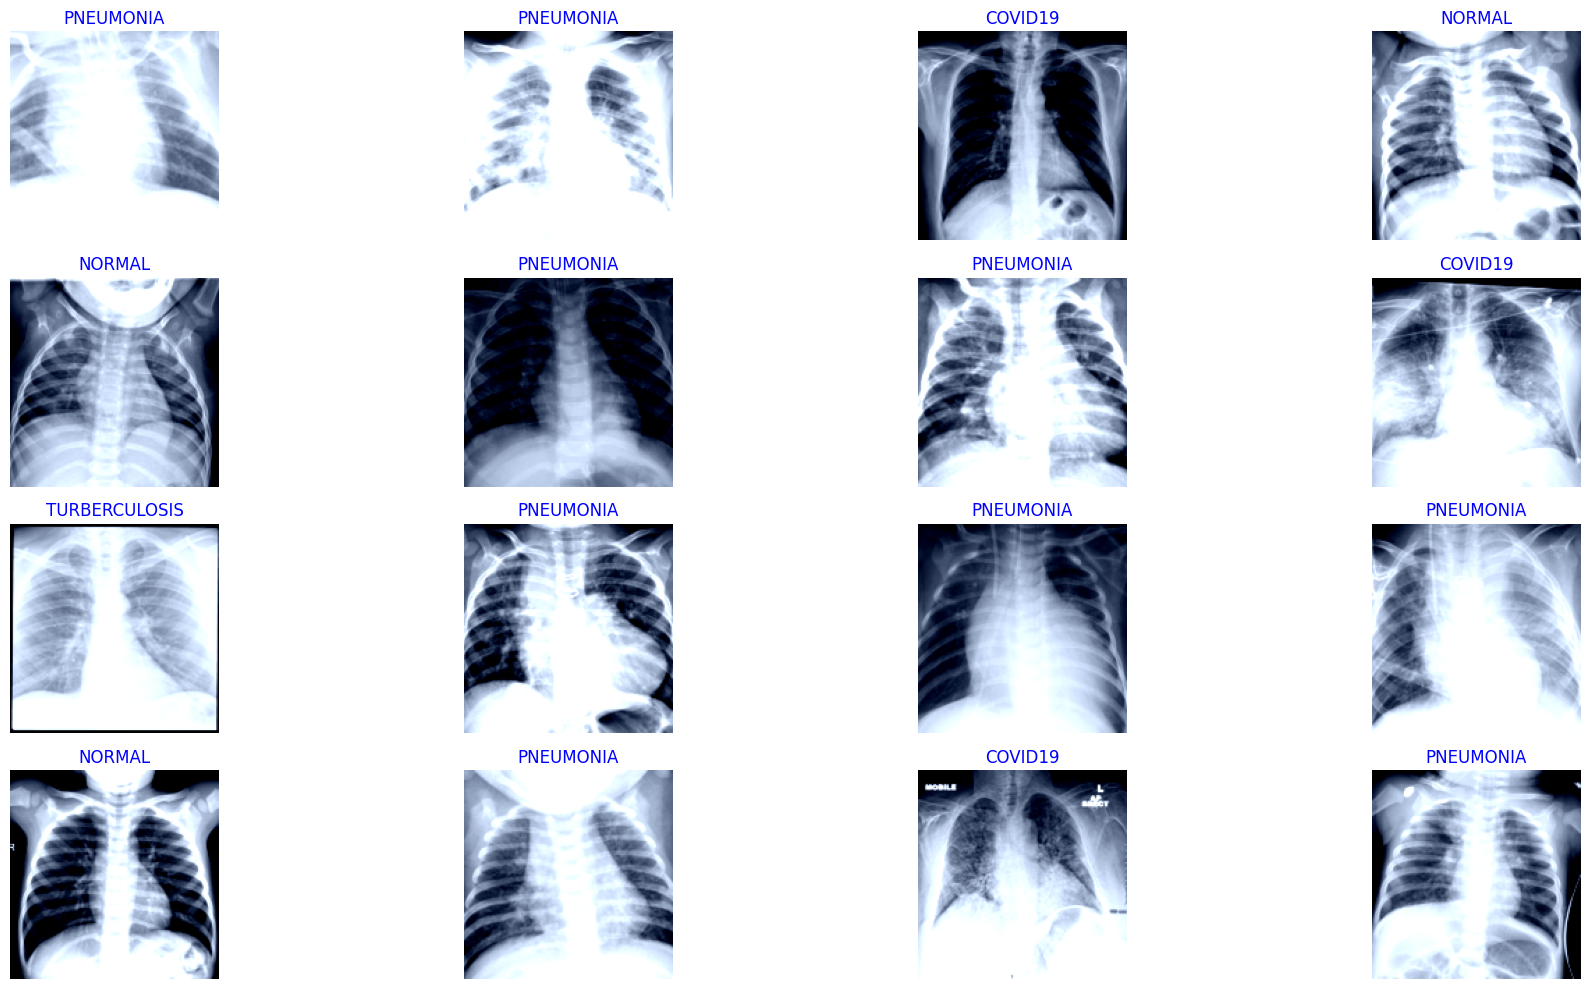

In [31]:
classes = dataset.classes  # This retrieves class names directly from your dataset

# Fetch a batch of images and labels from 'train_loader'
dataiter = iter(train_loader)
images, labels = next(dataiter)  

# Function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Display images
plt.figure(figsize=(20, 10))
for i in range(16):
    if i >= len(images):  # Check to prevent trying to display more images than available in the batch
        break
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
    class_name = classes[labels[i]]  # Fetch the class name using the label as index
    plt.title(class_name, color='blue', fontsize=12)

plt.tight_layout()
plt.show()

# Custom CNN architecture

In [32]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):  
        super(CustomCNN, self).__init__()
        # Convolutional layers and pooling layer 
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
    
        self.fc1 = nn.Linear(64 * 37 * 37, 512)
        
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 37 * 37)  
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1 = CustomCNN(num_classes=4).to(device) 

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the CNN model

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model

# Train the model
model1 = train_model(model1, criterion, optimizer, scheduler, num_epochs=10)

Epoch 0/9 Loss: 1.8843 Acc: 0.8629
Epoch 1/9 Loss: 0.1816 Acc: 0.9352
Epoch 2/9 Loss: 0.1376 Acc: 0.9514
Epoch 3/9 Loss: 0.1084 Acc: 0.9612
Epoch 4/9 Loss: 0.0779 Acc: 0.9706
Epoch 5/9 Loss: 0.0867 Acc: 0.9673


In [ ]:
# Evaluate the model on the test set
def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0
    
    # Disabling gradient calculation is useful for inference
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass to calculate the output
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # Update the running loss and correct count
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    # Calculate the loss and accuracy for the entire dataset
    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Validation Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

# Call the evaluate_model function
evaluate_model(model1, criterion, val_loader)

Validation Loss: 0.1032 Acc: 0.9705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


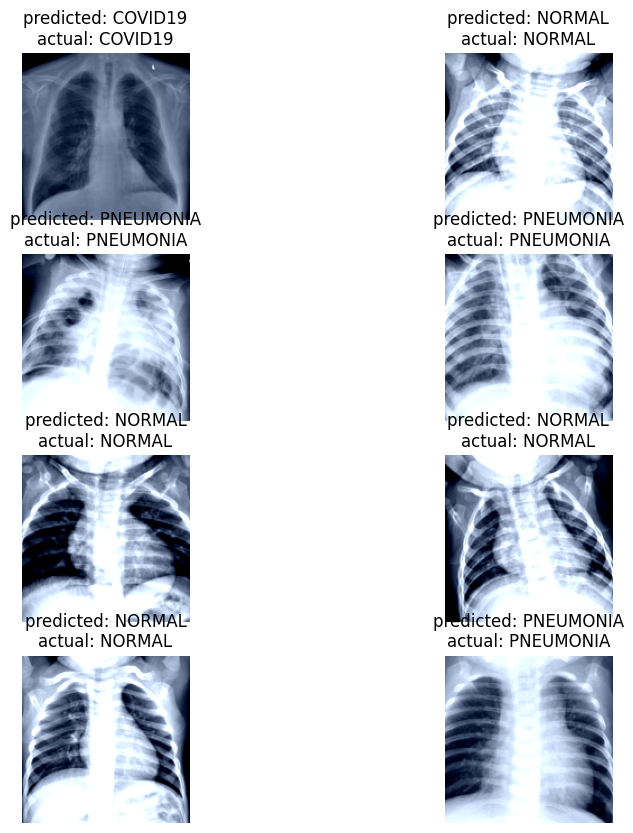

In [ ]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}\nactual: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model1, num_images=8)


# Confusion matrix and CLassification report for CNN

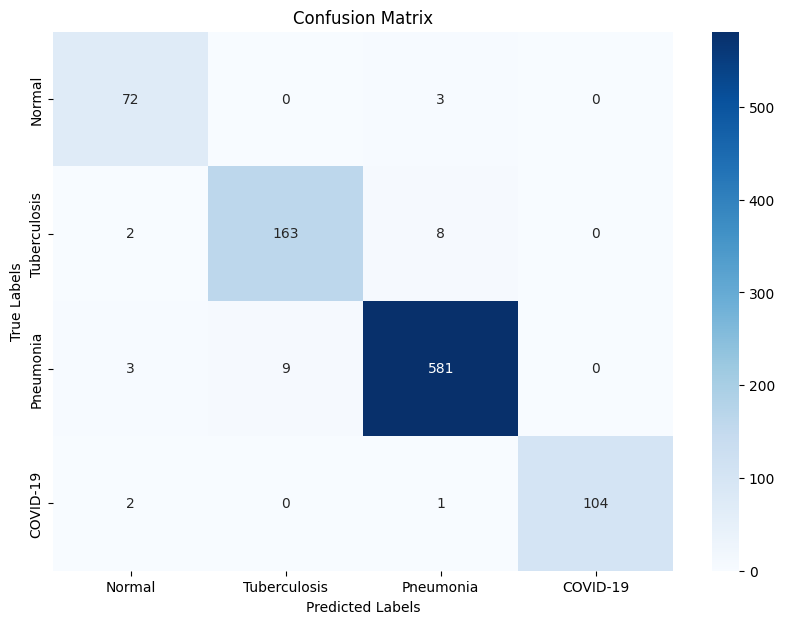

In [ ]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # We do not need gradient computation for this
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

# Using the function to get predictions and true labels
predictions, true_labels = get_predictions_and_labels(model1, val_loader)

class_names = ['Normal', 'Tuberculosis', 'Pneumonia', 'COVID-19']

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.91      0.96      0.94        75
Tuberculosis       0.95      0.94      0.94       173
   Pneumonia       0.98      0.98      0.98       593
    COVID-19       1.00      0.97      0.99       107

    accuracy                           0.97       948
   macro avg       0.96      0.96      0.96       948
weighted avg       0.97      0.97      0.97       948



# Restnet50

In [ ]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=4, dropout_probability=0.5):
        super(CustomResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_probability),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model2 = CustomResNet50(num_classes=4, dropout_probability=0.5)

c:\Users\krrah\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krrah\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

model2 = train_model(model2, criterion, optimizer, scheduler, num_epochs=10)


Epoch 0/9 Loss: 0.2937 Acc: 0.8959
Epoch 1/9 Loss: 0.1798 Acc: 0.9374
Epoch 2/9 Loss: 0.1484 Acc: 0.9487
Epoch 3/9 Loss: 0.0977 Acc: 0.9648
Epoch 4/9 Loss: 0.0950 Acc: 0.9682
Epoch 5/9 Loss: 0.0744 Acc: 0.9731
Epoch 6/9 Loss: 0.0711 Acc: 0.9752
Epoch 7/9 Loss: 0.0236 Acc: 0.9928
Epoch 8/9 Loss: 0.0111 Acc: 0.9977
Epoch 9/9 Loss: 0.0089 Acc: 0.9982


In [ ]:
evaluate_model(model2, criterion, val_loader)

Validation Loss: 0.0622 Acc: 0.9778


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


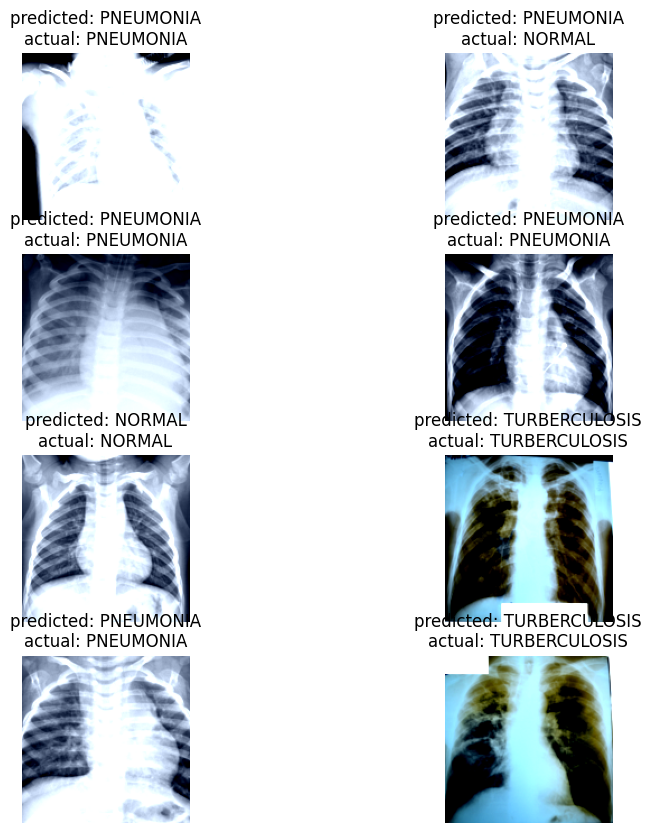

In [ ]:
visualize_model(model2, num_images=8)

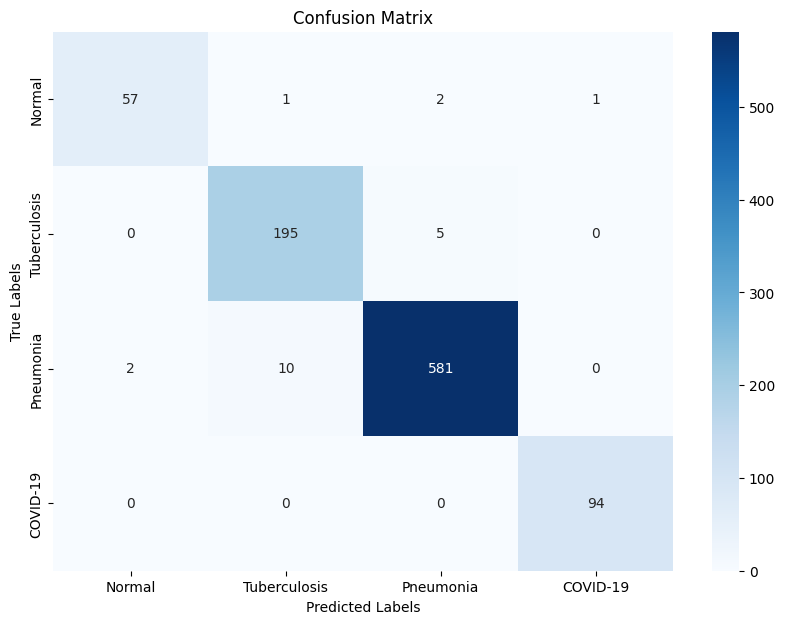

In [ ]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad(): 
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

predictions, true_labels = get_predictions_and_labels(model2, val_loader)

class_names = ['Normal', 'Tuberculosis', 'Pneumonia', 'COVID-19']

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.97      0.93      0.95        61
Tuberculosis       0.95      0.97      0.96       200
   Pneumonia       0.99      0.98      0.98       593
    COVID-19       0.99      1.00      0.99        94

    accuracy                           0.98       948
   macro avg       0.97      0.97      0.97       948
weighted avg       0.98      0.98      0.98       948



# Dataset B

In [33]:
data_dir = r"C:\Users\ismaeeel\Downloads\archive\TB_Chest_Radiography_Database" 
dataset = datasets.ImageFolder(data_dir)

# Define split sizes
train_split = 0.7
val_split = 0.15  
test_split = 0.15  # Ensure train_split + val_split + test_split == 1

# Shuffle & split the data
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_split_end = int(np.floor(train_split * dataset_size))
val_split_end = train_split_end + int(np.floor(val_split * dataset_size))

train_indices = indices[:train_split_end]
val_indices = indices[train_split_end:val_split_end]
test_indices = indices[val_split_end:]

# Create data subsets for each split
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Augmentation and transformation settings for training
train_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation does not use augmentation but follows the same resizing and normalization
val_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transforms = {
    'train': train_transforms,
    'val': val_transforms,
}

In [ ]:
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['val'] 

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

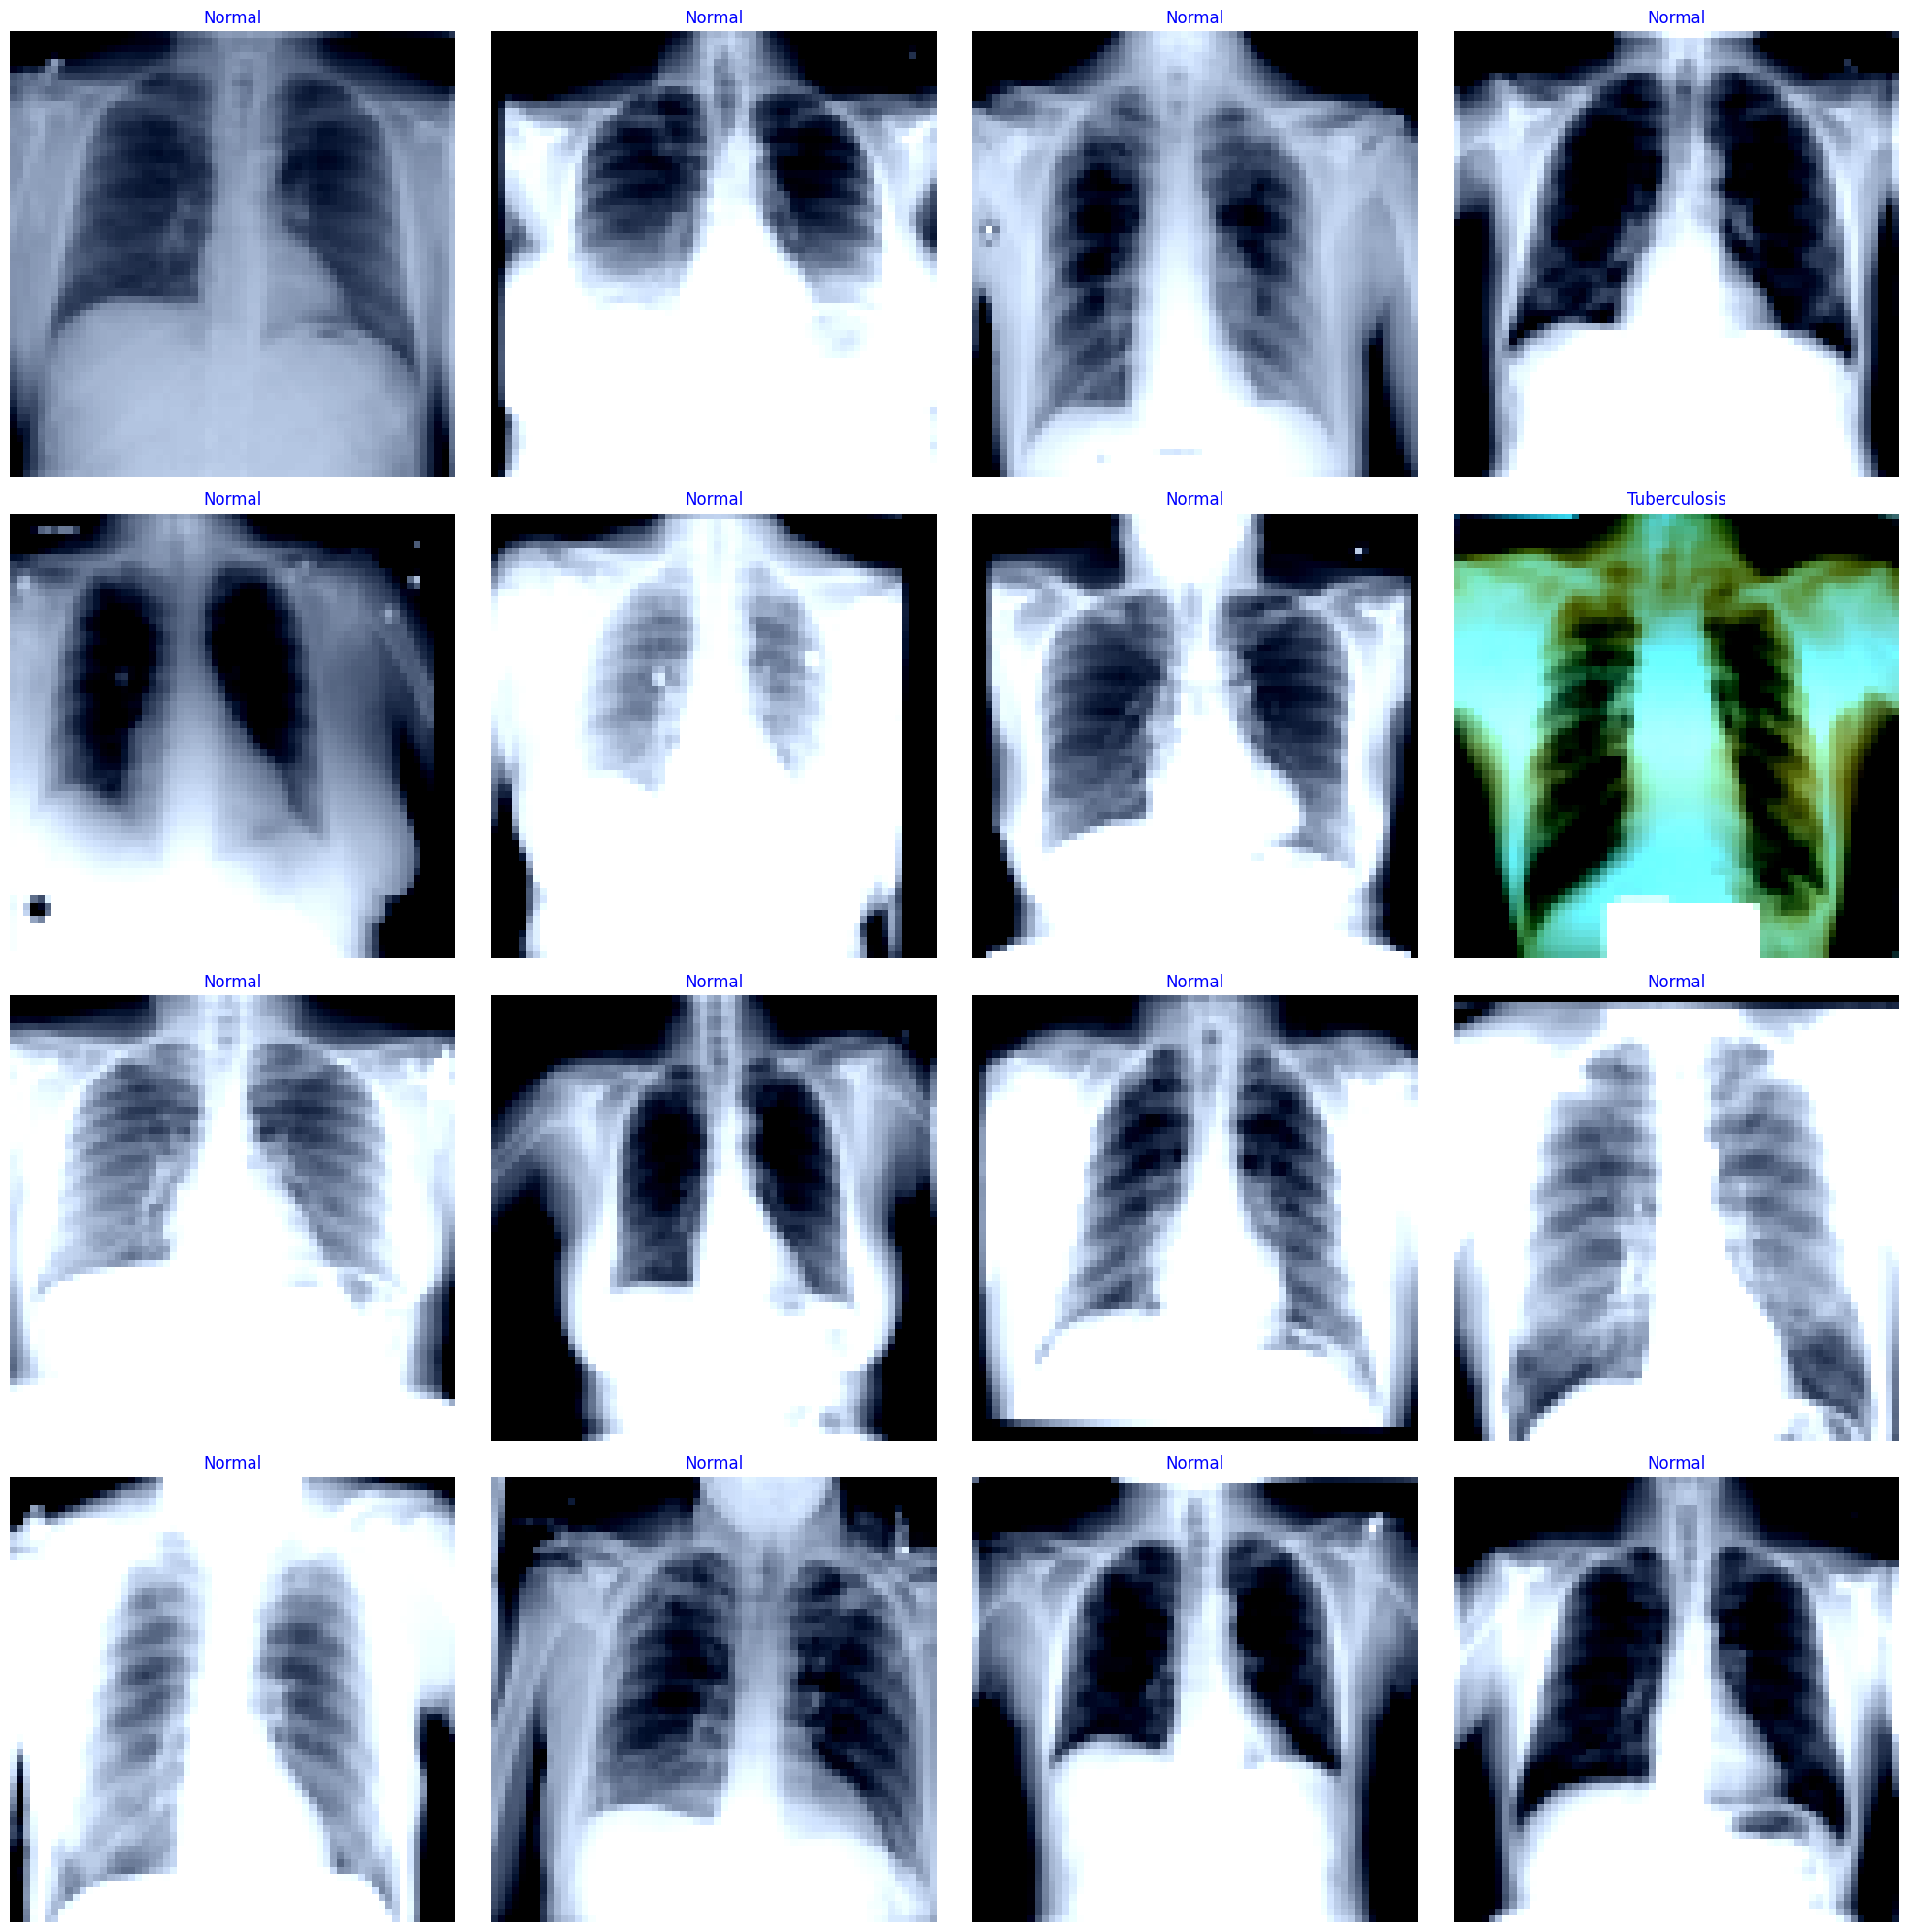

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)  

# Function to denormalize image for visualization
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.axis('off')

class_names = dataset.classes

plt.figure(figsize=(20, 20))

# Display 16 images from the batch
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    imshow(images[i])
    ax.set_title(class_names[labels[i]], color='blue', fontsize=12)

plt.tight_layout()
plt.show()

# Restnet50 model for datasetB

In [ ]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=2, dropout_probability=0.5):
        super(CustomResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_probability),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = CustomResNet50(num_classes=2, dropout_probability=0.5)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

# Training Function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model

# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24 Loss: 0.1592 Acc: 0.9442
Epoch 1/24 Loss: 0.0681 Acc: 0.9789
Epoch 2/24 Loss: 0.0534 Acc: 0.9840
Epoch 3/24 Loss: 0.0259 Acc: 0.9922
Epoch 4/24 Loss: 0.0430 Acc: 0.9854
Epoch 5/24 Loss: 0.0543 Acc: 0.9830
Epoch 6/24 Loss: 0.0307 Acc: 0.9891
Epoch 7/24 Loss: 0.0080 Acc: 0.9973
Epoch 8/24 Loss: 0.0050 Acc: 0.9993
Epoch 9/24 Loss: 0.0036 Acc: 0.9993
Epoch 10/24 Loss: 0.0018 Acc: 0.9997
Epoch 11/24 Loss: 0.0168 Acc: 0.9990
Epoch 12/24 Loss: 0.0017 Acc: 0.9997
Epoch 13/24 Loss: 0.0010 Acc: 1.0000
Epoch 14/24 Loss: 0.0011 Acc: 0.9997
Epoch 15/24 Loss: 0.0006 Acc: 1.0000
Epoch 16/24 Loss: 0.0007 Acc: 1.0000
Epoch 17/24 Loss: 0.0095 Acc: 0.9993
Epoch 18/24 Loss: 0.0005 Acc: 1.0000
Epoch 19/24 Loss: 0.0063 Acc: 0.9990
Epoch 20/24 Loss: 0.0008 Acc: 0.9997
Epoch 21/24 Loss: 0.0036 Acc: 0.9986
Epoch 22/24 Loss: 0.0004 Acc: 1.0000
Epoch 23/24 Loss: 0.0005 Acc: 1.0000
Epoch 24/24 Loss: 0.0005 Acc: 1.0000


In [ ]:
def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0
    
    # Disabling gradient calculation is useful for inference
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass to calculate the output
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # Update the running loss and correct count
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    # Calculate the loss and accuracy for the entire dataset
    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Validation Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

# Call the evaluate_model function
evaluate_model(model, criterion, val_loader)


Validation Loss: 0.0394 Acc: 0.9905


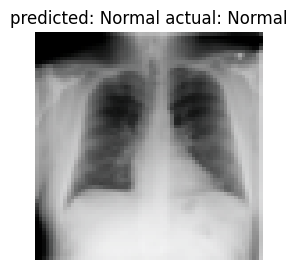

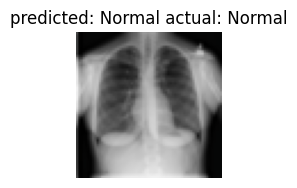

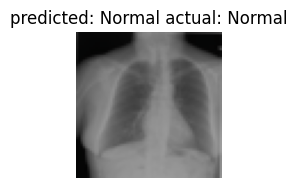

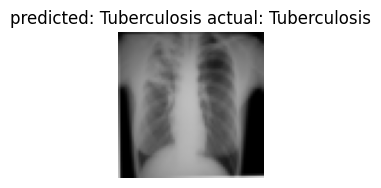

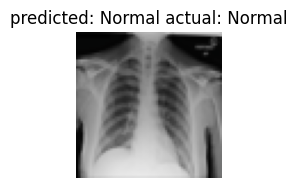

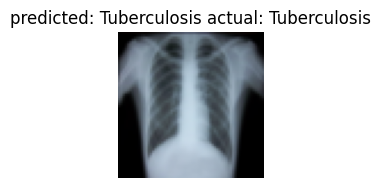

In [ ]:
label_names = {0: 'Normal', 1: 'Tuberculosis'}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 7)) 

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 3, 3, images_so_far) 
                ax.axis('off')
                ax.set_title(f'predicted: {label_names[int(preds[j])]} actual: {label_names[int(labels[j])]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show()
                    return
        model.train(mode=was_training)

visualize_model(model, num_images=6)


[[533   3]
 [  2  92]]


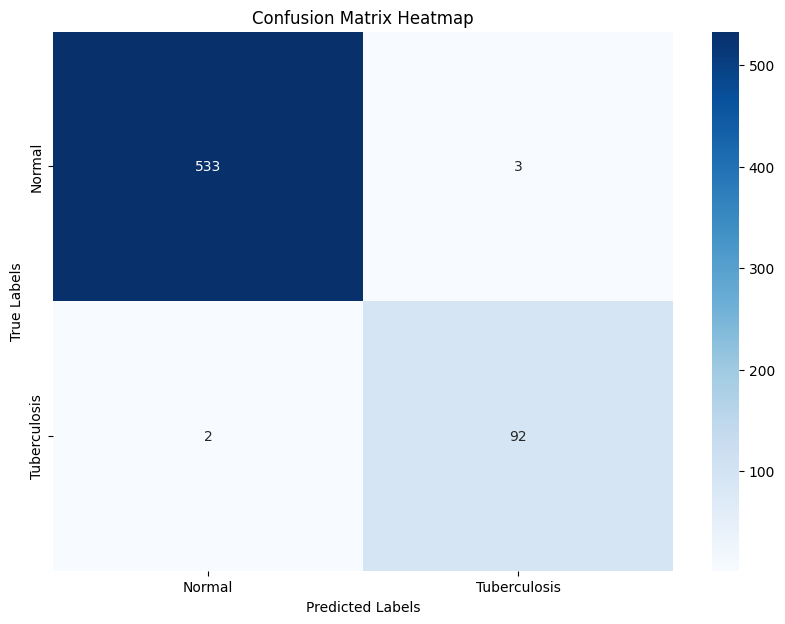

In [ ]:
def get_all_preds_labels(model, loader):
    all_preds = []
    all_labels = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

all_preds, all_labels = get_all_preds_labels(model, test_loader)

cm = confusion_matrix(all_labels, all_preds)
print(cm)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds, target_names=label_names.values()))

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       536
Tuberculosis       0.97      0.98      0.97        94

    accuracy                           0.99       630
   macro avg       0.98      0.99      0.98       630
weighted avg       0.99      0.99      0.99       630



# CNN

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 16 * 16)  # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model3 = CustomCNN().to(device)

# Loss and Optimizer
optimizer = optim.Adam(model3.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model3 = train_model(model3, criterion, optimizer, scheduler, num_epochs=10)

Epoch 0/9 Loss: 0.4264 Acc: 0.9330
Epoch 1/9 Loss: 0.1080 Acc: 0.9677
Epoch 2/9 Loss: 0.0724 Acc: 0.9786
Epoch 3/9 Loss: 0.0475 Acc: 0.9850
Epoch 4/9 Loss: 0.0361 Acc: 0.9901
Epoch 5/9 Loss: 0.0293 Acc: 0.9905
Epoch 6/9 Loss: 0.0525 Acc: 0.9830
Epoch 7/9 Loss: 0.0243 Acc: 0.9918
Epoch 8/9 Loss: 0.0160 Acc: 0.9952
Epoch 9/9 Loss: 0.0150 Acc: 0.9959


In [ ]:
evaluate_model(model3, criterion, val_loader)

Validation Loss: 0.0356 Acc: 0.9857


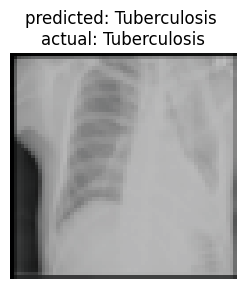

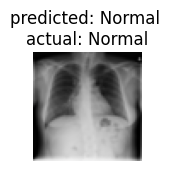

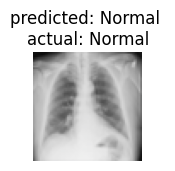

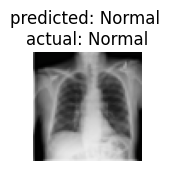

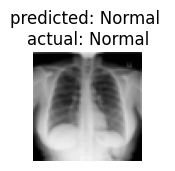

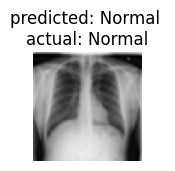

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model_predictions(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {label_names[preds[j].item()]} \nactual: {label_names[labels[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

label_names = {0: 'Normal', 1: 'Tuberculosis'}

visualize_model_predictions(model3, val_loader, num_images=6)

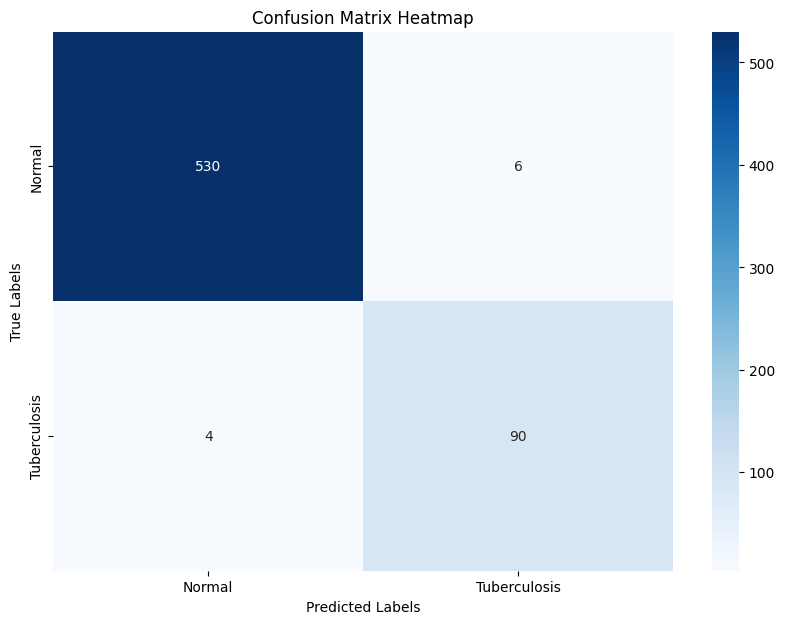

In [ ]:
all_preds, all_labels = get_all_preds_labels(model3, test_loader)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds, target_names=label_names.values()))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       536
Tuberculosis       0.94      0.96      0.95        94

    accuracy                           0.98       630
   macro avg       0.97      0.97      0.97       630
weighted avg       0.98      0.98      0.98       630

